# Project A14 KAGGLE - A MOVIE SCORE PREDICTION
## Predicting IMDb movie ratings from given parameters
Marten Mark, Karl Soosalu, Mark Alexander Helme


# All kind of imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

from keras.layers import Dense, BatchNormalization
from keras.models import Sequential
from keras.optimizers import SGD

# Preprocessing

In [2]:
# Reading data
movies = pd.read_csv("IMDb movies.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Converting date_published into year, month and day
movies["date_published"].iloc[83917] = "2019" #Replacing anomaly
date = lambda x: pd.Series([i for i in x.split('-')])
newCols = movies['date_published'].apply(date)
newCols = newCols.fillna(0)

movies["year_new"] = newCols[0]
movies["month"] = newCols[1]
movies["day"] = newCols[2]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [4]:
# Removing columns
movies = movies.drop(["imdb_title_id", "title", "original_title", "year", "description", "budget", "usa_gross_income", "worlwide_gross_income", "metascore", "votes", "reviews_from_users", "reviews_from_critics", "date_published"], axis=1)

In [5]:
movies["language"] = movies.language.replace("None", np.nan)

In [6]:
movies = pd.concat([movies.drop('language', 1), movies['language'].str.get_dummies(sep=", ")], 1)
movies = pd.concat([movies.drop('genre', 1), movies['genre'].str.get_dummies(sep=", ")], 1)
movies = pd.concat([movies.drop('country', 1), movies['country'].str.get_dummies(sep=", ")], 1)

In [7]:
movies = movies.drop(["production_company", "director", "actors", "writer"], axis=1)
movies

,duration,avg_vote,year_new,month,day,Abkhazian,Aboriginal,Acholi,Afrikaans,Akan,Albanian,Algonquin,American Sign Language,Amharic,Ancient (to 1453),Apache languages,Arabic,Aragonese,Aramaic,Arapaho,Armenian,Aromanian,Assamese,Assyrian Neo-Aramaic,Athapascan languages,Australian Sign Language,Awadhi,Aymara,Azerbaijani,Bable,Balinese,Bambara,Basque,Belarusian,Bemba,Bengali,Berber languages,Bhojpuri,Bicolano,Bosnian,...,Singapore,Slovakia,Slovenia,Somalia,South Africa,South Korea,Soviet Union,Spain,Sri Lanka,Sudan,Suriname,Svalbard And Jan Mayen,Swaziland,Sweden,Switzerland,Syria,Taiwan,Tajikistan,Tanzania,Thailand,The Democratic Republic Of Congo,Trinidad and Tobago,Tunisia,Turkey,UK,USA,Uganda,Ukraine,United Arab Emirates,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Germany,Yemen,Yugoslavia,Zaire,Zambia,Zimbabwe
0,45,5.9,1894,10,09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,70,6.1,1906,12,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,53,5.8,1911,08,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100,5.2,1912,11,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,68,7.0,1911,03,06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85850,95,5.3,2020,01,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
85851,103,7.7,2020,02,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
85852,130,7.9,2019,03,08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
85853,98,6.4,2019,03,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Machine learning models

In [8]:
X = movies.drop("avg_vote", axis=1)
y = movies.avg_vote

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=0)

#### Linear regression

In [9]:
linear = LinearRegression().fit(X_train, y_train)
pred_linear = linear.predict(X_test)
pred_linear[pred_linear > 10] = 10
pred_linear[pred_linear < 0] = 0

mae_linear = mean_absolute_error(y_test, pred_linear)
print ("Linear regression mean absolute error (MAE):", round(mae_linear,4))

Linear regression mean absolute error (MAE): 0.7721


#### Lasso

In [10]:
lasso= Lasso().fit(X_train, y_train)
pred_lasso = lasso.predict(X_test)
pred_lasso[pred_lasso > 10] = 10
pred_lasso[pred_lasso < 0] = 0

mae_lasso = mean_absolute_error(y_test, pred_lasso)
print ("Lasso mean absolute error (MAE):", round(mae_lasso,4))

Lasso mean absolute error (MAE): 0.8934


#### K nearest neighbor regression

In [11]:
neighbors= KNeighborsRegressor().fit(X_train, y_train)
pred_neighbors = neighbors.predict(X_test)
pred_neighbors[pred_neighbors > 10] = 10
pred_neighbors[pred_neighbors < 0] = 0

mae_neighbors = mean_absolute_error(y_test, pred_neighbors)
print ("Nearest neighbors mean absolute error (MAE):", round(mae_neighbors,4))

Nearest neighbors mean absolute error (MAE): 0.9009


#### Ridge

In [12]:
ridge= Ridge().fit(X_train, y_train)
pred_ridge = ridge.predict(X_test)
pred_ridge[pred_ridge > 10] = 10
pred_ridge[pred_ridge < 0] = 0

mae_ridge = mean_absolute_error(y_test, pred_ridge)
print ("Ridge mean absolute error (MAE):", round(mae_ridge,4))

Ridge mean absolute error (MAE): 0.7678


# Experimenting with neural networks

In [18]:
X = movies.drop("avg_vote", axis=1)
y = movies[["avg_vote"]]

# Normalization
scalerX= preprocessing.MinMaxScaler()
X[['duration',	'year_new',	'month',	'day']] = scalerX.fit_transform(X[['duration',	'year_new',	'month',	'day']])
scalery= preprocessing.MinMaxScaler()
y = scalery.fit_transform(y[['avg_vote']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = Sequential()
model.add(Dense(64, activation="tanh", input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(32, activation="tanh"))
model.add(BatchNormalization())
model.add(Dense(16, activation="selu"))
model.add(BatchNormalization())
model.add(Dense(7, activation="linear"))
model.add(Dense(1, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="sgd")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                31424     
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
dense_8 (Dense)              (None, 7)                

In [19]:
model.fit(X_train, y_train, epochs=4, validation_data=(X_test, y_test), batch_size=256, verbose=True)

y_pred = model.predict(X_test)
y_pred = scalery.inverse_transform(y_pred)
y_test = scalery.inverse_transform(y_test)

mae_neural = mean_absolute_error(y_test, y_pred)
print ("Neural networks mean absolute error (MAE):", round(mae_neural,4))

Epoch 1/4
235/235 [==============================] - 1s 6ms/step - loss: 0.1396 - val_loss: 0.0323
Epoch 2/4
235/235 [==============================] - 1s 4ms/step - loss: 0.0293 - val_loss: 0.0222
Epoch 3/4
235/235 [==============================] - 1s 4ms/step - loss: 0.0222 - val_loss: 0.0202
Epoch 4/4
235/235 [==============================] - 1s 4ms/step - loss: 0.0193 - val_loss: 0.0185
Neural networks mean absolute error (MAE): 0.9303


#### Summary

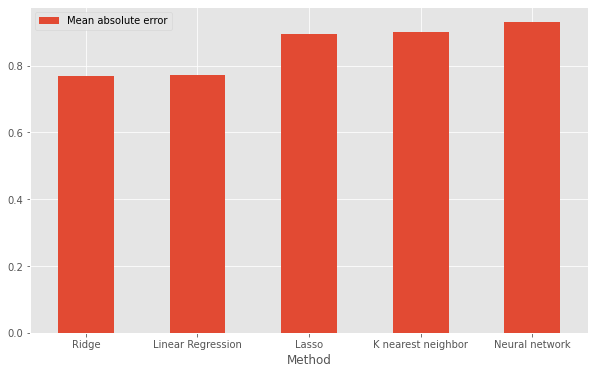

In [20]:
#Graph
import matplotlib.pyplot as plt
import matplotlib
dframe_linear=round(mae_linear,4)
dframe_lasso=round(mae_lasso,4)
dframe_neighbors=round(mae_neighbors,4)
dframe_ridge=round(mae_ridge,4)
dframe_neural=round(mae_neural,4)


method_results=[dframe_ridge,dframe_linear,dframe_lasso,dframe_neighbors,dframe_neural]
method_names=["Ridge","Linear Regression","Lasso","K nearest neighbor","Neural network"]


plt.rcParams['figure.figsize'] = (10,6)
matplotlib.style.use('ggplot')
dframe=pd.DataFrame({'Method':method_names, 'Mean absolute error':method_results})
dframe.sort_values('Mean absolute error',ascending=True).plot.bar(x='Method',y='Mean absolute error',rot=0)


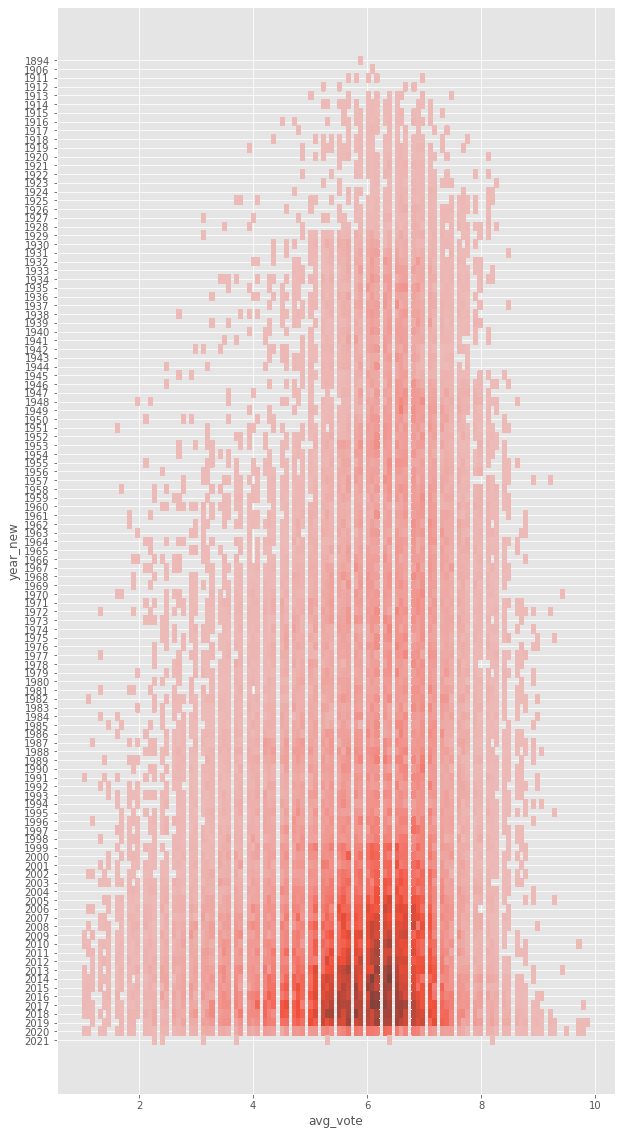

In [21]:
import seaborn as sns

movies_copy = movies.copy()
movies_copy = movies_copy.sort_values(by='year_new')

plt.figure(figsize=(10,20))
ax = sns.histplot(x = 'avg_vote', y = 'year_new', data = movies_copy)
plt.show()

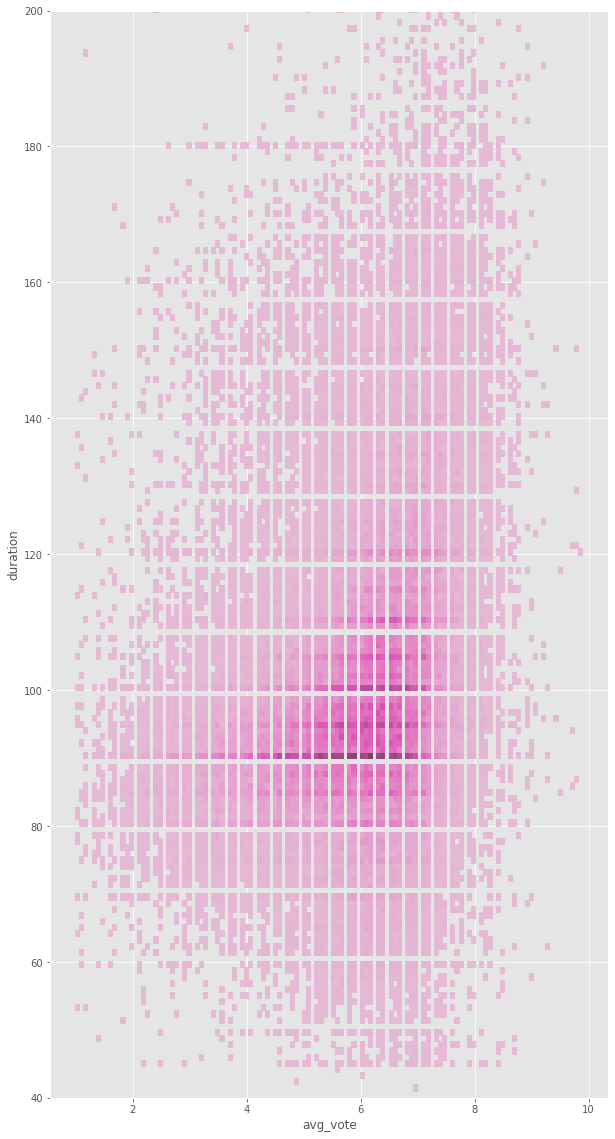

In [22]:
movies_copy = movies_copy.sort_values(by='duration')

plt.figure(figsize=(10,20))
ax = sns.histplot(x = 'avg_vote', y = 'duration', data = movies_copy, color = '#e377c2')
plt.ylim(40, 200)
plt.show()